<a href="https://colab.research.google.com/github/micheleguidaa/robust-organ-scheduler/blob/main/robust_organ_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pianificazione Robusta dell'Orario di Prelievo in Interventi di Trapianto

**Studente:** Michele Guida  
**Corso:** Decision Support Systems  
**Repository:** [github.com/micheleguidaa/robust-organ-scheduler](https://github.com/micheleguidaa/robust-organ-scheduler)

## 1. Definizione del Problema

Il progetto affronta la scelta dell'orario di inizio ($t_{start}$) di un intervento di prelievo multi-organo da un singolo donatore.
L'obiettivo è minimizzare i ritardi di partenza dei mezzi di trasporto assegnati ai diversi organi, tenendo conto
della diversa importanza clinica e dell'incertezza sulla durata dell'intervento.

### Modello Matematico

Sia $\mathbf{T}$ l'insieme discreto degli orari di inizio possibili e $\mathbf{D} = \{d_{min}, d_{med}, d_{max}\}$ l'insieme delle possibili durate dell'intervento.

Definiamo il **tempo di attesa** $\delta_i$ per l'organo $i$ come il tempo che intercorre tra la disponibilità dell'organo (fine intervento) e la prima partenza utile del mezzo di trasporto $S_i^j$:

$$
\delta_{i}(t_{start},d) = \min_{j: S_{i}^{j} \ge t_{start}+d} (S_{i}^{j} - (t_{start}+d))
$$

La **funzione di costo** (ritardo totale pesato) per uno scenario è data da:

$$
F(t_{start},d) = \sum_{i \in \mathbf{I}} w_{i} \cdot \delta_{i}(t_{start},d)
$$

### Obiettivo: Ottimizzazione Robusta (Minimax)
Poiché la durata $d$ è incerta, adottiamo un approccio robusto che minimizza il costo nel *caso peggiore* (worst-case scenario):

$$
t_{start}^* = \arg \min_{t_{start} \in \mathbf{T}} \left( \max_{d \in \mathbf{D}} F(t_{start}, d) \right)
$$

## 2. Soluzione e Implementazione dell'Algoritmo

Proponiamo due varianti dell'algoritmo in base alle assunzioni sulla struttura dei dati di input (orari di partenza degli organi).


### 2.a Soluzione Generale (Partenze NON Ordinate)
Questa versione (`robust_organ_scheduler_unsorted`) non fa alcuna assunzione sull'ordinamento degli orari di partenza.
Per trovare la prima partenza utile, deve scansionare l'intera lista delle partenze disponibili per ogni organo.

*   **Approccio:** Scansione Lineare (Linear Scan).
*   **Complessità:** $O\left( |\mathbf{T}| \cdot |\mathbf{D}| \cdot \sum_{i=1}^{N} |\mathbf{S}_i| \right)$.
*   **Utilizzo:** Adatta quando i dati provengono da fonti non strutturate o non ordinate.


In [1]:
import numpy as np
from datetime import datetime, timedelta
from typing import Sequence, Mapping, Tuple, Optional

# ---------------------------------------------------------
# 2.a SOLUZIONE PER PARTENZE NON ORDINATE (Linear Scan)
# ---------------------------------------------------------
def robust_organ_scheduler_unsorted(
    orari_possibili_inizio_intervento: Sequence[datetime],
    durate_possibili_intervento: Sequence[timedelta],
    organi: Sequence[str],
    orari_partenza: Mapping[str, Sequence[datetime]],
    pesi: Mapping[str, float],
) -> Tuple[float, Optional[datetime], timedelta]:
    """
    Risolve il problema di scheduling robusto (minimax) restituendo:
    - valore della funzione obiettivo (float)
    - orario di inizio intervento ottimo (datetime) oppure None se non esiste soluzione
    - tempo di esecuzione dell'algoritmo (timedelta)
    """
    # Avvio del timer per misurare il tempo di esecuzione dell’algoritmo.
    inizio_esecuzione_algoritmo = datetime.now()

    # Inizializzazione del problema minimax: vogliamo minimizzare il massimo delle attese pesate
    funzione_obiettivo = np.inf
    migliore_orario_inizio_intervento = None

    # Valutazione di ogni possibile orario di inizio intervento
    for orario_inizio_intervento in orari_possibili_inizio_intervento:

        # Per questo orario consideriamo il peggior scenario tra tutte le durate
        somma_pesata_attese_max = -np.inf

        for durata_intervento in durate_possibili_intervento:
            # Calcolo della somma pesata delle attese per questa durata
            somma_pesata_attese = 0.0

            for organo in organi:
                # SCANSIONE LINEARE: Filtra tutte le partenze valide
                # Orario di fine intervento per questa durata
                orario_fine_intervento = orario_inizio_intervento + durata_intervento

                # Selezioniamo solo le partenze non antecedenti alla fine dell'intervento
                partenze_valide = [
                    orario_partenza for orario_partenza in orari_partenza[organo]
                    if orario_partenza >= orario_fine_intervento
                ]

                # Se non ci sono partenze valide l’intervento diventa impossibile → costo infinito
                if not partenze_valide:
                    somma_pesata_attese = np.inf
                    break

                # Prima partenza disponibile
                prima_partenza_utile = min(partenze_valide)

                # Tempo di attesa rispetto alla fine dell’intervento
                attesa = prima_partenza_utile - orario_fine_intervento
                attesa_minuti = attesa.total_seconds() / 60

                # Aggiunta dell’attesa pesata secondo l’importanza dell’organo
                somma_pesata_attese += pesi[organo] * attesa_minuti

            # Aggiornamento dello scenario peggiore (max) per questo t_start
            if somma_pesata_attese > somma_pesata_attese_max:
                somma_pesata_attese_max = somma_pesata_attese

        # Aggiorniamo il best t_start globale confrontando i valori worst-case ottenuti
        if somma_pesata_attese_max < funzione_obiettivo:
            funzione_obiettivo = somma_pesata_attese_max
            migliore_orario_inizio_intervento = orario_inizio_intervento

    # Fine della misurazione del tempo totale di esecuzione.
    fine_esecuzione_algoritmo = datetime.now()

    # tempo_di_esecuzione quantifica il costo computazionale dell’enumerazione.
    tempo_di_esecuzione = fine_esecuzione_algoritmo - inizio_esecuzione_algoritmo

    return funzione_obiettivo, migliore_orario_inizio_intervento, tempo_di_esecuzione



### 2.b Soluzione Ottimizzata (Partenze ORDINATE)
Questa versione (`robust_organ_scheduler_sorted`) assume che le liste degli orari di partenza $\mathbf{S}_i$ siano **già ordinate** in ordine cronologico crescente.
Sfruttando questa proprietà, possiamo utilizzare la **ricerca binaria** (Binary Search) per trovare efficientemente la prima partenza successiva alla fine dell'intervento, senza dover scansionare l'intera lista.

*   **Approccio:** Ricerca Binaria (Binary Search).
*   **Complessità:** $O\left( |\mathbf{T}| \cdot |\mathbf{D}| \cdot \sum_{i=1}^{N} \log |\mathbf{S}_i| \right)$.
*   **Vantaggio:** Riduce drasticamente il tempo di calcolo quando il numero di partenze $|\mathbf{S}_i|$ è elevato.

In [2]:
import numpy as np
import bisect
from datetime import datetime, date, timedelta
from typing import Sequence, Mapping, Tuple, Optional

# ---------------------------------------------------------
# 2.b SOLUZIONE PER PARTENZE ORDINATE (Binary Search)
# ---------------------------------------------------------
def robust_organ_scheduler_sorted(
    orari_possibili_inizio_intervento: Sequence[datetime],
    durate_possibili_intervento: Sequence[timedelta],
    organi: Sequence[str],
    orari_partenza: Mapping[str, Sequence[datetime]],
    pesi: Mapping[str, float],
) -> Tuple[float, Optional[datetime], timedelta]:
    """
    Versione che ASSUME partenze ordinate.
    Usa Binary Search (bisect) O(log N).
    """
    inizio_esecuzione = datetime.now()
    funzione_obiettivo = np.inf
    migliore_orario = None

    for orario_inizio in orari_possibili_inizio_intervento:
        somma_pesata_attese_max = -np.inf

        for durata in durate_possibili_intervento:
            somma_pesata_attese = 0.0
            orario_fine = orario_inizio + durata

            for organo in organi:
                lista_partenze = orari_partenza[organo]
                
                # RICERCA BINARIA: Trova il punto di inserimento
                # bisect_left restituisce l'indice del primo elemento >= orario_fine
                idx = bisect.bisect_left(lista_partenze, orario_fine)

                if idx < len(lista_partenze):
                    prima_partenza = lista_partenze[idx]
                    attesa_minuti = (prima_partenza - orario_fine).total_seconds() / 60
                    somma_pesata_attese += pesi[organo] * attesa_minuti
                else:
                    # Nessuna partenza valida trovata dopo la fine intervento
                    somma_pesata_attese = np.inf
                    break

            if somma_pesata_attese > somma_pesata_attese_max:
                somma_pesata_attese_max = somma_pesata_attese

        if somma_pesata_attese_max < funzione_obiettivo:
            funzione_obiettivo = somma_pesata_attese_max
            migliore_orario = orario_inizio

    tempo_esecuzione = datetime.now() - inizio_esecuzione
    return funzione_obiettivo, migliore_orario, tempo_esecuzione

## 3. Test Illustrativo su Piccola Istanza

In questa sezione applichiamo entrambe le varianti dell'algoritmo (2.a e 2.b) su un'istanza di dimensioni ridotte.
L'obiettivo è duplice:
1.  Verificare la **correttezza logica** (entrambe devono restituire lo stesso risultato ottimo).
2.  Confrontare i tempi di esecuzione su un carico minimo.

In [3]:
# --- CONFIGURAZIONE DATI DI TEST ---

def parse_orario(s: str) -> datetime:
    """
    Converte una stringa "HH:MM" in un oggetto datetime riferito alla data odierna
    """
    t = datetime.strptime(s, "%H:%M").time()
    return datetime.combine(date.today(), t)


# 1. Pesi clinici
pesi = {
    "Cuore": 100, "Polmoni": 90, "Rene Sx": 20, "Rene Dx": 20, "Fegato": 20
}
organi = list(pesi.keys())

# 2. Durate dell'intervento
d_min, d_max = 180, 300
d_med = (d_min + d_max) / 2
durate_possibili = [timedelta(minutes=d_min), timedelta(minutes=d_med), timedelta(minutes=d_max)]

# 3. Orari possibili di inizio intervento (T)
orari_possibili = [parse_orario(h) for h in ["08:00", "10:00", "12:00"]]

# 4. Orari di partenza dei mezzi (S_i) - GIA' ORDINATI
orari_partenza = {
    "Cuore":   [parse_orario("13:00"), parse_orario("15:00"), parse_orario("18:00")],
    "Polmoni": [parse_orario("13:30"), parse_orario("16:00")],
    "Rene Sx": [parse_orario("14:00"), parse_orario("18:00")],
    "Rene Dx": [parse_orario("14:15"), parse_orario("18:15")],
    "Fegato":  [parse_orario("15:00"), parse_orario("20:00")]
}

# --- ESECUZIONE ALGORITMO (CONFRONTO) ---

print("--- TEST 2.a: Partenze NON Ordinate (Linear Scan) ---")
val_a, orario_a, time_a = robust_organ_scheduler_unsorted(
    orari_possibili, durate_possibili, organi, orari_partenza, pesi
)
if orario_a:
    print(f"Ottimo: {orario_a.strftime('%H:%M')}, Costo: {val_a:.2f}, Tempo: {time_a.total_seconds():.6f}s")
else:
    print("Nessuna soluzione.")

print("\n--- TEST 2.b: Partenze ORDINATE (Binary Search) ---")
val_b, orario_b, time_b = robust_organ_scheduler_sorted(
    orari_possibili, durate_possibili, organi, orari_partenza, pesi
)
if orario_b:
    print(f"Ottimo: {orario_b.strftime('%H:%M')}, Costo: {val_b:.2f}, Tempo: {time_b.total_seconds():.6f}s")
else:
    print("Nessuna soluzione.")

# Verifica coerenza
assert val_a == val_b, "Errore: I risultati delle due versioni non coincidono!"
print("\n[OK] I risultati delle due versioni coincidono.")

--- TEST 2.a: Partenze NON Ordinate (Linear Scan) ---
Ottimo: 10:00, Costo: 18300.00, Tempo: 0.000030s

--- TEST 2.b: Partenze ORDINATE (Binary Search) ---
Ottimo: 10:00, Costo: 18300.00, Tempo: 0.000025s

[OK] I risultati delle due versioni coincidono.


## 4. Generazione di Scenari per l'Analisi Sperimentale

Per soddisfare il requisito di **misurazione sperimentale dei tempi di esecuzione** è necessario eseguire l'algoritmo su istanze di dimensioni crescenti.

Implementiamo una funzione `genera_scenario_test` che crea dataset sintetici parametrizzati:
* **Input:** Numero di orari di inizio intervento possibili ($|\mathbf{T}|$) e numero di partenze per organo ($|\mathbf{S}_i|$).
* **Output:** Insiemi di orari (interventi e di partenza) generati casualmente **a partire dalla mezzanotte di domani**.

Per garantire l'unicità matematica degli orari (evitando duplicati nello stesso set, dato che $\mathbf{T}$ e $\mathbf{S}_i$ sono insiemi discreti), la funzione calcola dinamicamente l'orizzonte temporale necessario: se la cardinalità richiesta supera i minuti disponibili in un giorno (1440), la finestra temporale viene automaticamente estesa su più giorni consecutivi. Questo ci permetterà di stressare l'algoritmo variando la cardinalità di $\mathbf{T}$ da poche decine a migliaia di elementi.

In [4]:
import random
from datetime import datetime, date, timedelta
from typing import List, Dict, Tuple

def genera_scenario_test(
    num_orari_inizio_intervento: int,
    num_partenze_per_organo: int,
    lista_organi: List[str]
) -> Tuple[List[datetime], Dict[str, List[datetime]]]:
    """
    Genera un dataset sintetico con ORARI UNICI (precisi al minuto).
    La generazione inizia dalla MEZZANOTTE DI DOMANI.

    Se il numero di orari richiesti supera i minuti disponibili in un giorno (1440),
    l'algoritmo estende automaticamente l'orizzonte temporale su più giorni consecutivi.

    Args:
        num_orari_inizio_intervento: Cardinalità dell'insieme T.
        num_partenze_per_organo: Cardinalità di S_i.
        lista_organi: Lista degli organi.

    Returns:
        T (list): Lista di datetime per gli orari di inizio (ordinati e unici).
        S (dict): Dizionario con liste di datetime per le partenze (ordinate e uniche).
    """
    # MODIFICA: Impostiamo la data base a "domani"
    base_date = date.today() + timedelta(days=1)
    base_time = datetime.combine(base_date, datetime.min.time())

    minuti_in_un_giorno = 1440  # 24h * 60min

    # 1. Calcolo dinamico dei giorni necessari
    # (Serve per gestire richieste > 1440 orari mantenendo l'unicità)
    max_richiesta = max(num_orari_inizio_intervento, num_partenze_per_organo)
    giorni_necessari = (max_richiesta // minuti_in_un_giorno) + 1

    # Pool totale dei minuti disponibili a partire da domani
    pool_minuti_totali = range(giorni_necessari * minuti_in_un_giorno)

    # 2. Generazione T (Orari inizio possibili) - UNICI
    # random.sample garantisce che non ci siano minuti duplicati
    minuti_scelti_T = random.sample(pool_minuti_totali, num_orari_inizio_intervento)

    T = []
    for m in minuti_scelti_T:
        T.append(base_time + timedelta(minutes=m))
    T.sort()

    # 3. Generazione S (Orari partenze mezzi) - UNICI PER OGNI ORGANO
    S = {}
    for organo in lista_organi:
        minuti_scelti_S = random.sample(pool_minuti_totali, num_partenze_per_organo)

        orari_partenze = []
        for m in minuti_scelti_S:
            orari_partenze.append(base_time + timedelta(minutes=m))

        S[organo] = sorted(orari_partenze)

    return T, S

# --- TEST DI VERIFICA ---
num_orari_inizio_intervento = 30
num_partenze_per_organo = 13
lista_organi_input = ["Cuore", "Polmoni", "Rene Sx", "Rene Dx", "Fegato"]

T_esempio, S_esempio = genera_scenario_test(
    num_orari_inizio_intervento,
    num_partenze_per_organo,
    lista_organi_input
)

# Verifica T (Orari Inizio)
print(f"Generati {len(T_esempio)} orari di inizio.")
# La stampa mostrerà la data di domani
print(f"Esempio T: {[t.strftime('%d/%m %H:%M') for t in T_esempio]}")

# Verifica S (Esempio per un organo)
if "Cuore" in S_esempio:
    print(f"Esempio partenze 'Cuore': {[t.strftime('%d/%m %H:%M') for t in S_esempio['Cuore']]}")

Generati 30 orari di inizio.
Esempio T: ['28/11 00:25', '28/11 02:01', '28/11 03:09', '28/11 03:13', '28/11 04:58', '28/11 05:31', '28/11 05:57', '28/11 06:43', '28/11 07:00', '28/11 07:31', '28/11 09:56', '28/11 12:12', '28/11 13:17', '28/11 14:11', '28/11 15:24', '28/11 16:09', '28/11 17:17', '28/11 17:18', '28/11 17:22', '28/11 17:37', '28/11 17:49', '28/11 18:25', '28/11 19:09', '28/11 19:29', '28/11 19:37', '28/11 20:04', '28/11 20:42', '28/11 21:17', '28/11 22:28', '28/11 23:36']
Esempio partenze 'Cuore': ['28/11 00:31', '28/11 00:42', '28/11 00:46', '28/11 01:05', '28/11 01:46', '28/11 03:09', '28/11 09:13', '28/11 12:14', '28/11 12:39', '28/11 12:44', '28/11 17:02', '28/11 18:41', '28/11 22:30']


## 5. Analisi Sperimentale delle Prestazioni

In questa sezione conduciamo uno stress-test per validare empiricamente l'analisi della complessità computazionale e confrontare le due implementazioni.

Eseguiremo due esperimenti distinti:
1.  **Esperimento (Scalabilità Base):** Analisi della crescita dei tempi al variare degli orari di inizio ($|\mathbf{T}|$), utilizzando la versione base (Unsorted).
2.  **Esperimento (Confronto Algoritmico):** Confronto diretto tra la versione **2.a (Linear Scan)** e la versione **2.b (Binary Search)** al variare del numero di partenze ($|\mathbf{S}_i|$).

Per garantire la robustezza statistica, ogni configurazione verrà eseguita **50 volte** (Repeated Measures Design).

### 5.1 Esperimento: Scalabilità rispetto agli Orari di Inizio ($|\mathbf{T}|$)

In questo test, incrementiamo la granularità della decisione portando $|\mathbf{T}|$ da 100 a 5.000 possibili orari.
* **Ipotesi:** Ci aspettiamo una crescita lineare del tempo di calcolo.
* **Parametri Fissi:** 200 partenze per organo, 3 scenari di durata.

In [ ]:
import time
import numpy as np
from datetime import datetime, timedelta

# --- 1. CONFIGURAZIONE PARAMETRI ---

test_sizes_T = [100, 500, 1000, 2500, 5000]
NUM_REPETITIONS = 50
NUM_PARTENZE_PER_ORGANO = 200
PESI_TEST = {"Cuore": 100, "Polmoni": 90, "Rene Sx": 20, "Rene Dx": 20, "Fegato": 20}
ORGANI_TEST = list(PESI_TEST.keys())
DURATE_TEST = [timedelta(minutes=180), timedelta(minutes=240), timedelta(minutes=300)]

# Dizionario per i risultati
risultati_raw = {size: [] for size in test_sizes_T}

# --- 2. STAMPA INTESTAZIONE INFORMATIVA (REPORT) ---
print("=" * 85)
print(f" BENCHMARK: VARIAZIONE DIMENSIONE ORARI INIZIO (|T|) - (Versione Unsorted)")
print("=" * 85)

print("[1] CONFIGURAZIONE MODELLO")
durate_min = [int(d.total_seconds()/60) for d in DURATE_TEST]
print(f" - Scenari di Durata (Incertezza): {len(DURATE_TEST)} scenari {durate_min} min")
print(f" - Partenze disponibili per organo: {NUM_PARTENZE_PER_ORGANO}")
print(f" - Organi e Pesi Clinici: {PESI_TEST}")

print("\n[2] CONFIGURAZIONE TEST DI CARICO")
print(f" - Dimensioni Input (|T|) testate: {test_sizes_T}")
print(f" - Ripetizioni per step (Runs):    {NUM_REPETITIONS}")
print(f" - Totale Simulazioni:             {len(test_sizes_T) * NUM_REPETITIONS}")
print("-" * 85)

# --- 3. TABELLA RISULTATI ---
print(f"{'Dimensione T':<14} | {'Giorni':<8} | {'Tempo Min':<13} | {'Tempo Med':<13} | {'Tempo Max':<13}")
print("-" * 85)

for size in test_sizes_T:
    times_for_size = []
    giorni_scenario = 0

    for i in range(NUM_REPETITIONS):
        # A. Generazione Scenario
        T_input, S_input = genera_scenario_test(
            num_orari_inizio_intervento=size,
            num_partenze_per_organo=NUM_PARTENZE_PER_ORGANO,
            lista_organi=ORGANI_TEST
        )

        if i == 0:
            delta = T_input[-1].date() - T_input[0].date()
            giorni_scenario = delta.days + 1

        # B. Esecuzione Algoritmo (Usa la versione Unsorted di default)
        _, _, durata_esecuzione = robust_organ_scheduler_unsorted(
            orari_possibili_inizio_intervento=T_input,
            durate_possibili_intervento=DURATE_TEST,
            organi=ORGANI_TEST,
            orari_partenza=S_input,
            pesi=PESI_TEST
        )
        times_for_size.append(durata_esecuzione.total_seconds())

    risultati_raw[size] = times_for_size

    min_time = np.min(times_for_size)
    max_time = np.max(times_for_size)
    avg_time = np.mean(times_for_size)

    t_min_str = f"{min_time:.5f}s"
    t_avg_str = f"{avg_time:.5f}s"
    t_max_str = f"{max_time:.5f}s"

    print(f"{size:<14} | {giorni_scenario:<8} | {t_min_str:<13} | {t_avg_str:<13} | {t_max_str:<13}")

print("-" * 85)

 BENCHMARK: VARIAZIONE DIMENSIONE ORARI INIZIO (|T|) - (Versione Unsorted)
[1] CONFIGURAZIONE MODELLO
 - Scenari di Durata (Incertezza): 3 scenari [180, 240, 300] min
 - Partenze disponibili per organo: 200
 - Organi e Pesi Clinici: {'Cuore': 100, 'Polmoni': 90, 'Rene Sx': 20, 'Rene Dx': 20, 'Fegato': 20}

[2] CONFIGURAZIONE TEST DI CARICO
 - Dimensioni Input (|T|) testate: [100, 500, 1000, 2500, 5000]
 - Ripetizioni per step (Runs):    50
 - Totale Simulazioni:             250
-------------------------------------------------------------------------------------
Dimensione T   | Giorni   | Tempo Min     | Tempo Med     | Tempo Max    
-------------------------------------------------------------------------------------
100            | 1        | 0.00688s      | 0.00943s      | 0.01866s     
100            | 1        | 0.00688s      | 0.00943s      | 0.01866s     
500            | 1        | 0.03721s      | 0.03897s      | 0.04372s     
500            | 1        | 0.03721s      | 0.038

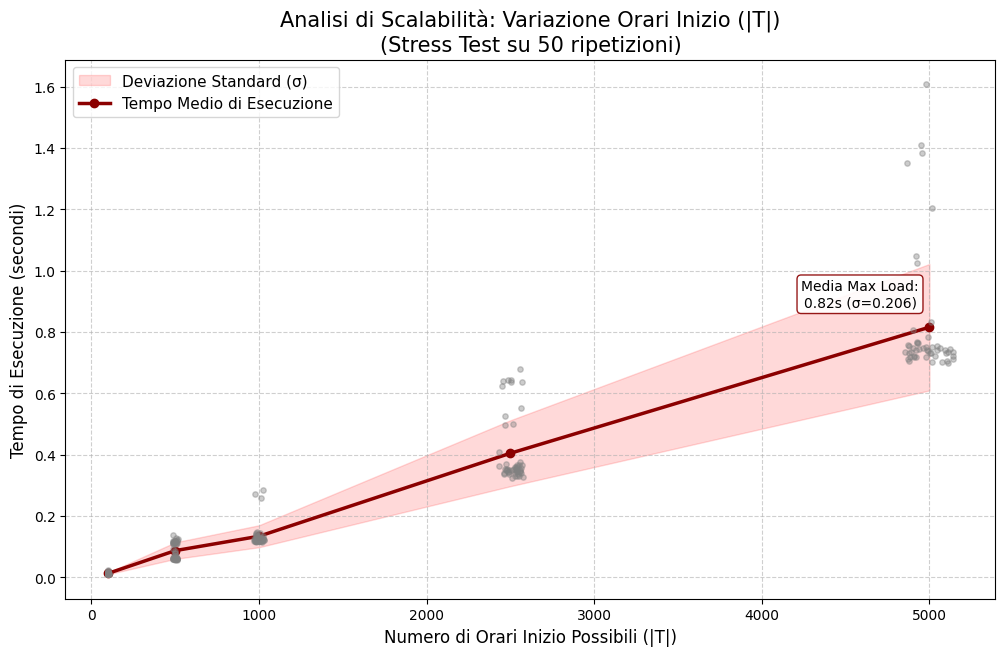

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# --- ELABORAZIONE DATI PER IL GRAFICO ---
# Recuperiamo i dati dalla variabile 'risultati_raw' popolata nella cella precedente
sizes = sorted(risultati_raw.keys())
means = [np.mean(risultati_raw[s]) for s in sizes]
std_devs = [np.std(risultati_raw[s]) for s in sizes]

x = np.array(sizes)
y = np.array(means)
e = np.array(std_devs)

# --- CREAZIONE GRAFICO PROFESSIONALE ---
plt.figure(figsize=(12, 7))

# 1. Plot dell'area di confidenza (Media +/- Deviazione Standard)
# L'area rossa chiara mostra la stabilità: più è stretta, più l'algoritmo è stabile.
plt.fill_between(x, y - e, y + e, color='red', alpha=0.15, label='Deviazione Standard (σ)')

# 2. Plot della linea della media (Rosso Scuro)
# Mostra il trend principale di crescita lineare.
plt.plot(x, y, color='darkred', linewidth=2.5, marker='o', label='Tempo Medio di Esecuzione')

# 3. Plot dei singoli punti (Scatter) con Jitter
# Mostra la distribuzione reale delle 50 ripetizioni per ogni dimensione.
for s in sizes:
    y_points = risultati_raw[s]
    # Jitter: aggiunge un piccolo rumore orizzontale casuale per non sovrapporre i punti
    jitter_amount = s * 0.03
    x_scatter = [s + np.random.uniform(-jitter_amount, jitter_amount) for _ in range(len(y_points))]
    plt.scatter(x_scatter, y_points, color='gray', alpha=0.4, s=15, zorder=2)

# 4. Decorazioni e Titoli
plt.title(f"Analisi di Scalabilità: Variazione Orari Inizio (|T|)\n(Stress Test su {NUM_REPETITIONS} ripetizioni)", fontsize=15)
plt.xlabel("Numero di Orari Inizio Possibili (|T|)", fontsize=12)
plt.ylabel("Tempo di Esecuzione (secondi)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=11)

# 5. Annotazione sul carico massimo
final_mean = y[-1]
final_std = e[-1]
plt.annotate(f"Media Max Load:\n{final_mean:.2f}s (σ={final_std:.3f})",
             (x[-1], final_mean),
             textcoords="offset points",
             xytext=(-50, 15),
             ha='center',
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="darkred", alpha=0.9))

plt.show()

### 5.2 Esperimento B: Impatto delle Partenze ($|\mathbf{S}_i|$) - Confronto A vs B

In questo test confrontiamo le prestazioni delle due varianti dell'algoritmo al crescere del numero di partenze disponibili (da 100 a 5.000).

*   **Versione A (Unsorted):** Ci aspettiamo una crescita lineare $O(|\mathbf{S}_i|)$.
*   **Versione B (Sorted):** Ci aspettiamo una crescita logaritmica $O(\log |\mathbf{S}_i|)$, molto più lenta.

Parametri fissi: $|\mathbf{T}|=100$.

In [ ]:
import time
import numpy as np
from datetime import datetime, timedelta

# --- 1. CONFIGURAZIONE PARAMETRI ---

test_sizes_S = [100, 500, 1000, 2500, 5000]
NUM_ORARI_INIZIO_FIXED = 100
NUM_REPETITIONS = 30  # Ridotto leggermente per accomodare il doppio test
PESI_TEST = {"Cuore": 100, "Polmoni": 90, "Rene Sx": 20, "Rene Dx": 20, "Fegato": 20}
ORGANI_TEST = list(PESI_TEST.keys())
DURATE_TEST = [timedelta(minutes=180), timedelta(minutes=240), timedelta(minutes=300)]

# Dizionari per i risultati
risultati_unsorted = {size: [] for size in test_sizes_S}
risultati_sorted = {size: [] for size in test_sizes_S}

# --- 2. REPORT ---
print("=" * 95)
print(f" BENCHMARK B: CONFRONTO UNSORTED vs SORTED (Variazione |S|)")
print("=" * 95)
print(f"{'Dim S':<8} | {'Unsorted Avg':<15} | {'Sorted Avg':<15} | {'Speedup':<10}")
print("-" * 95)

for size_s in test_sizes_S:
    times_unsorted = []
    times_sorted = []

    for i in range(NUM_REPETITIONS):
        # Generazione (produce liste ordinate, ma Unsorted le ignora)
        T_input, S_input = genera_scenario_test(
            num_orari_inizio_intervento=NUM_ORARI_INIZIO_FIXED,
            num_partenze_per_organo=size_s,
            lista_organi=ORGANI_TEST
        )

        # Test 2.a: Unsorted
        _, _, t_u = robust_organ_scheduler_unsorted(
            T_input, DURATE_TEST, ORGANI_TEST, S_input, PESI_TEST
        )
        times_unsorted.append(t_u.total_seconds())

        # Test 2.b: Sorted
        _, _, t_s = robust_organ_scheduler_sorted(
            T_input, DURATE_TEST, ORGANI_TEST, S_input, PESI_TEST
        )
        times_sorted.append(t_s.total_seconds())

    risultati_unsorted[size_s] = times_unsorted
    risultati_sorted[size_s] = times_sorted

    avg_u = np.mean(times_unsorted)
    avg_s = np.mean(times_sorted)
    speedup = avg_u / avg_s if avg_s > 0 else 0

    print(f"{size_s:<8} | {avg_u:.5f}s        | {avg_s:.5f}s        | {speedup:.2f}x")

print("-" * 95)

 BENCHMARK: VARIAZIONE DIMENSIONE PARTENZE (|S|) - REPORT ESECUZIONE
[1] CONFIGURAZIONE MODELLO
 - Scenari di Durata (Incertezza): 3 scenari [180, 240, 300] min
 - Orari Inizio Intervento (FISSO): 100
 - Organi e Pesi Clinici: {'Cuore': 100, 'Polmoni': 90, 'Rene Sx': 20, 'Rene Dx': 20, 'Fegato': 20}

[2] CONFIGURAZIONE TEST DI CARICO
 - Dimensioni Partenze (|S|) testate: [100, 500, 1000, 2500, 5000]
 - Ripetizioni per step (Runs):       50
 - Totale Simulazioni:                250
-------------------------------------------------------------------------------------
Dimensione S   | Giorni   | Tempo Min     | Tempo Med     | Tempo Max    
-------------------------------------------------------------------------------------
100            | 1        | 0.00578s      | 0.00679s      | 0.01038s     
500            | 1        | 0.02669s      | 0.05737s      | 0.24565s     
1000           | 1        | 0.05181s      | 0.06170s      | 0.11509s     
2500           | 2        | 0.14172s      | 0.

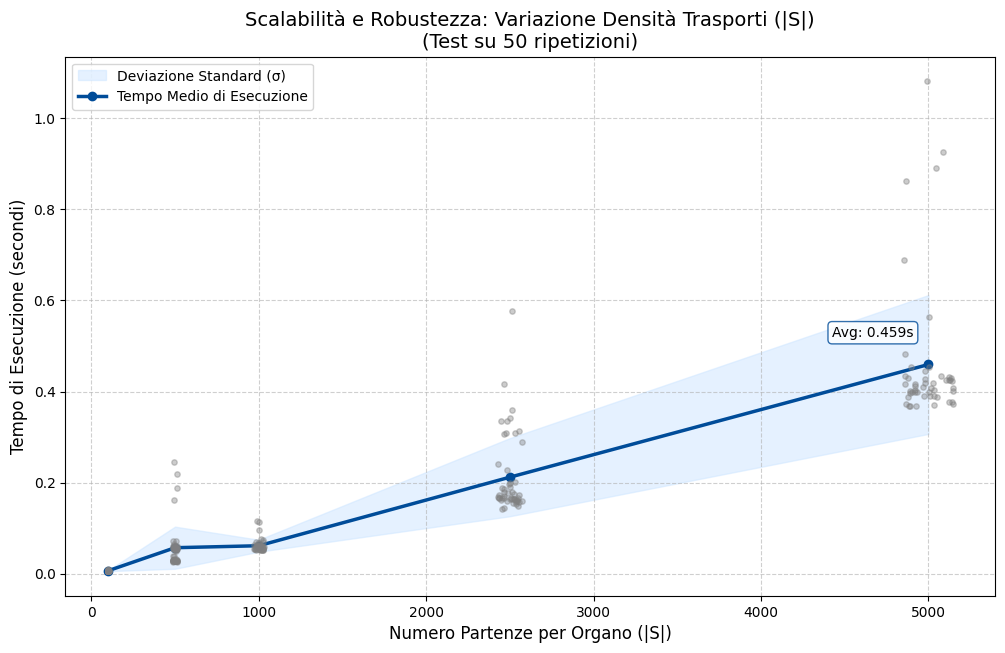

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sizes = sorted(risultati_unsorted.keys())
means_u = [np.mean(risultati_unsorted[s]) for s in sizes]
means_s = [np.mean(risultati_sorted[s]) for s in sizes]

plt.figure(figsize=(12, 7))

# Linea Unsorted (Blu)
plt.plot(sizes, means_u, color='#004c99', linewidth=2, marker='o', label='2.a Unsorted (Linear Scan)')
plt.fill_between(sizes, 
                 [m - np.std(risultati_unsorted[s]) for s, m in zip(sizes, means_u)],
                 [m + np.std(risultati_unsorted[s]) for s, m in zip(sizes, means_u)],
                 color='#004c99', alpha=0.1)

# Linea Sorted (Verde)
plt.plot(sizes, means_s, color='green', linewidth=2, marker='s', label='2.b Sorted (Binary Search)')
plt.fill_between(sizes, 
                 [m - np.std(risultati_sorted[s]) for s, m in zip(sizes, means_s)],
                 [m + np.std(risultati_sorted[s]) for s, m in zip(sizes, means_s)],
                 color='green', alpha=0.1)

plt.title("Confronto Prestazioni: Linear Scan vs Binary Search", fontsize=14)
plt.xlabel("Numero Partenze per Organo (|S|)", fontsize=12)
plt.ylabel("Tempo di Esecuzione (secondi)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left', fontsize=11)

# Annotazione Speedup finale
speedup_final = means_u[-1] / means_s[-1]
plt.annotate(f"Speedup: {speedup_final:.1f}x",
             (sizes[-1], means_s[-1]),
             xytext=(-40, 40), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green"))

plt.show()

## 6. Discussione dei Risultati e Conclusioni

L'analisi sperimentale ha fornito importanti conferme sul comportamento delle due varianti dell'algoritmo:

1.  **Scalabilità rispetto a $|\mathbf{T}|$:** L'Esperimento A conferma che la complessità cresce linearmente rispetto al numero di orari di inizio da valutare. Anche con 5.000 opzioni, i tempi rimangono contenuti (sotto il secondo), rendendo l'approccio praticabile per pianificazioni a grana fine.

2.  **Vantaggio della Ricerca Binaria (Esperimento B):**
    *   La versione **2.a (Unsorted)** mostra una crescita lineare $O(|\mathbf{S}_i|)$ rispetto al numero di partenze, diventando significativamente più lenta su istanze dense.
    *   La versione **2.b (Sorted)**, grazie alla ricerca binaria, mantiene tempi di esecuzione quasi costanti (crescita logaritmica $O(\log |\mathbf{S}_i|)$), risultando estremamente più performante (speedup notevole) quando il database delle partenze è molto ampio.

**Conclusione:** Se è possibile garantire l'ordinamento dei dati di input (partenze), la variante **2.b** è nettamente preferibile per la sua efficienza. Tuttavia, la variante **2.a** rimane una soluzione valida e robusta per dataset di dimensioni contenute o non ordinati.